In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import nibabel as nib
import sys
sys.path.insert(0, '..')
import argparse
from argparse import RawTextHelpFormatter
import odfs
import numpy as np
import os
import matplotlib.pyplot as plt

from dipy.data import get_sphere
from dipy.core.sphere import Sphere
from dipy.reconst.shm import sh_to_sf_matrix, sh_to_sf
from fury import actor, window
from IPython.core.display import Image
from PIL import Image as PILImage

from tqdm import tqdm
import time


In [3]:
# load an odf image represented in spherical harmonics
path = "/home/brysongray/data/BrainSuiteTutorialDWI/FRACT"

I = odfs.load_odf(path)
print(f'I shape: {I.shape}')

I shape: (45, 128, 256, 256)


In [4]:
files = os.listdir(path)
files.sort()
print(files)

['2523412.dwi.RAS.correct.SH.FRACT.001.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.002.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.003.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.004.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.005.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.006.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.007.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.008.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.009.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.010.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.011.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.012.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.013.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.014.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.015.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.016.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.017.T1_coord.nii.gz', '2523412.dwi.RAS.correct.SH.FRACT.018.T1_coord.

In [30]:
patch = I[:, 65, 120:130, 150:160]
# patch = I[:, 65, 150:160, 120:130]
voxel = I[:, 65, 125, 159]
print(patch.shape)

(45, 10, 10)


In [21]:
# helper functions for visualization
WINDOW_SIZE = (400, 400)
SAVEIM_FOLDER = 'images'
if not os.path.exists(SAVEIM_FOLDER):
    os.mkdir(SAVEIM_FOLDER)

def screenshot_animated_sf(sf, sphere, B=None, rot=True, norm=True, scale=True, title='Modeling', theta_step=30):
    '''
    Render a spherical function to file. Returns path to image.
    '''
    
    scene = window.Scene()
    scene.background(window.colors.white)
    
    sf_actor = actor.odf_slicer(sf[None, None, None, :],
                               sphere=sphere, colormap='jet',
                               norm=norm)#, radial_scale=scale)
    
#     sf_actor = actor.odf_slicer(sf,
#                            sphere=sphere, colormap='jet',
#                            norm=norm, B_matrix=B)#, radial_scale=scale)
        
    if rot:
        sf_actor.RotateX(-90)
#         sf_actor.RotateY(180)
#         sf_actor.RotateZ(180)
    scene.add(sf_actor)
    
    images = []
    n_frames = 360//theta_step
    for i in np.arange(n_frames):
#         sf_actor.RotateX(theta_step)
#         sf_actor.RotateY(theta_step)
        sf_actor.RotateZ(theta_step)
        scene.reset_clipping_range()
        images.append(PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE)))
        
    frame_duration = 15000 // theta_step
    filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
    images[0].save(filename, save_all=True, append_images=images[1:],
                  duration=frame_duration, optimize=False, loop=0)
    scene.clear()

    return filename
    
def screenshot_gradients(sph_gtab, title='Modeling'):
    scene = window.Scene()
    scene.background(window.colors.white)

    scene.add(actor.point(sph_gtab.vertices, window.colors.green, point_radius=0.05))

    outfile = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, size=WINDOW_SIZE, fname=outfile)

    scene.clear()
    return outfile

def display_slice(sf, B, sphere, norm=True):
    scene = window.Scene()
    scene.background(window.colors.white)
    
    sf_actor = actor.odf_slicer(sf,
                               sphere=sphere, colormap='jet',
                               norm=norm, B_matrix=B)#, radial_scale=scale)
    scene.add(sf_actor)
    
    window.show(scene, size=WINDOW_SIZE)

In [22]:
sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(2)

In [23]:
# signal_sphere = sh_to_sf(patch[:,5,2], sphere, sh_order=8)
B, Binv = sh_to_sf_matrix(sphere, 8)#, basis_type='tournier07')
print('Project back SH coefficient to the high resolution sphere')
signal_sphere = np.dot(voxel, B)
print('SF signal shape: ', signal_sphere.shape)

Project back SH coefficient to the high resolution sphere
SF signal shape:  (11554,)


In [24]:
patch.shape

(45, 10, 10)

In [35]:
display_slice(patch.transpose(1,2,0)[:,:,None], B, sphere)

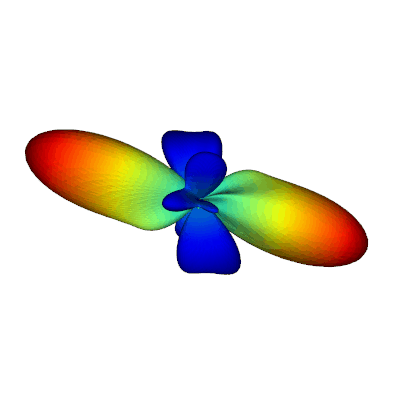

In [11]:
image = screenshot_animated_sf(signal_sphere, sphere, B=B, title='odf_signal_rot-X270_test', theta_step=360, rot=True)
Image(filename=image)

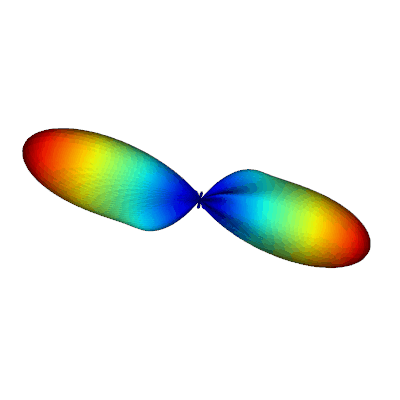

In [12]:
signal_sphere_nonnegative = np.where(signal_sphere >= 0., signal_sphere, 0.)
image = screenshot_animated_sf(signal_sphere_nonnegative, sphere, title='odf_signal_nonnegative_rot-X270_test', theta_step=360, rot=True)
Image(filename=image)

In [13]:
signal_sphere_nonnegative.shape

(11554,)

In [14]:
start = time.time()
patch_flat = patch.reshape((patch.shape[0],-1))
# cf = sf_to_cf(patch, 100, 64)
cf_flat = odfs.sh_to_cf(patch_flat, 100, 64)
end = time.time()
print(f'cf_flat shape: {cf_flat.shape}')
print(f'time to run: {end-start}')

integrating...: 100%|███████████████████████████| 64/64 [00:03<00:00, 16.95it/s]

time to run: 3.781951427459717


above block takes ~0.03415 sec/voxel
~80hr for 128x256x256 image

<IPython.core.display.Javascript object>


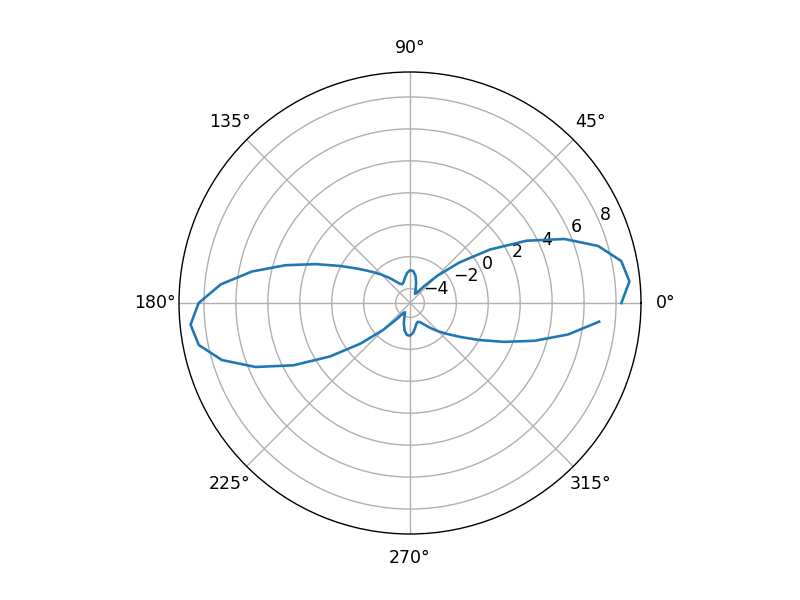

In [16]:
nbins = 64
step = 2*np.pi/nbins
bins = np.arange(0,2*np.pi,step)

fig, ax = plt.subplots(subplot_kw={'projection':'polar'})
plt.plot(bins,cf_flat[:,59])

In [29]:
cf_new = odfs.sh_to_cf_symbolic(patch_flat, 100, '/home/brysongray/diffusion_analyisis/')
print(f"cf_new shape: {cf_new.shape}")

spherical harmonic degree is 8.
found basis saved at /home/brysongray/diffusion_analyisis/Yphi.p
Y matrix shape: (100, 45)


<IPython.core.display.Javascript object>


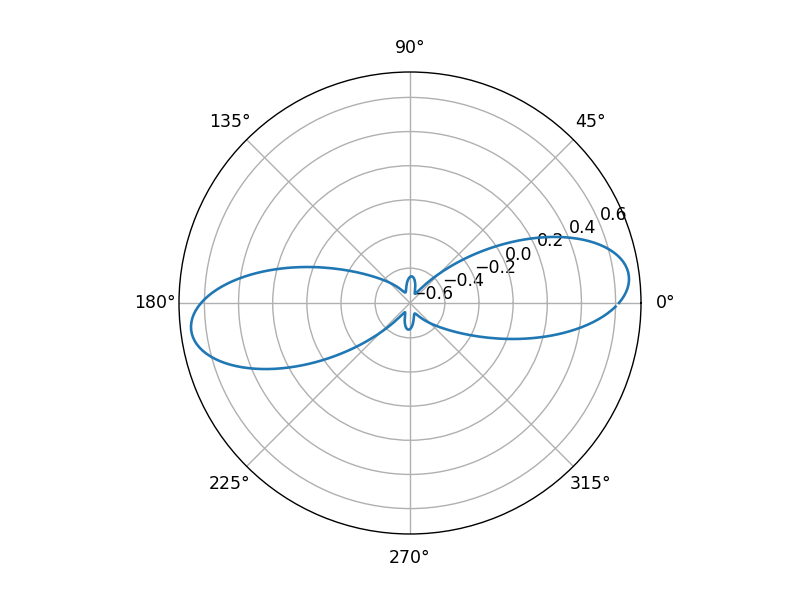

In [23]:
nbins = 64
step = 2*np.pi/nbins
bins = np.arange(0,2*np.pi,step)

fig, ax = plt.subplots(subplot_kw={'projection':'polar'})
plt.plot(bins,cf_new[:,59])

In [7]:
start = time.time()
cf = odfs.sh_to_cf_symbolic(I,64,'/home/brysongray/diffusion_analyisis/')
stop = time.time()
print(f"time elapsed: {stop-start}")

spherical harmonic degree is 8.
found basis saved at /home/brysongray/diffusion_analyisis/Yphi.p
Y matrix shape: (64, 45)


100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 184.60it/s]


time elapsed: 4.532378196716309


<IPython.core.display.Javascript object>


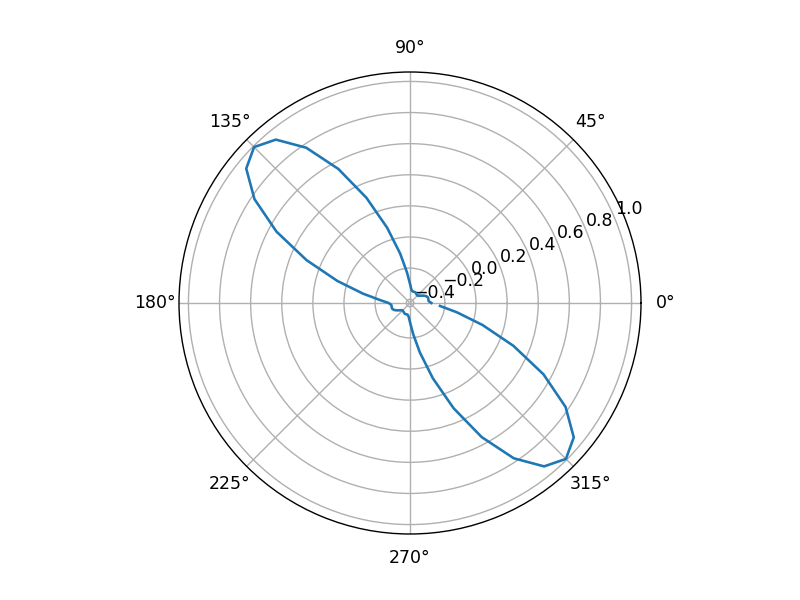

In [18]:
nbins = 64
step = 2*np.pi/nbins
bins = np.arange(0,2*np.pi,step)

fig, ax = plt.subplots(subplot_kw={'projection':'polar'})
plt.plot(bins,cf[:,68,128,124])

<IPython.core.display.Javascript object>


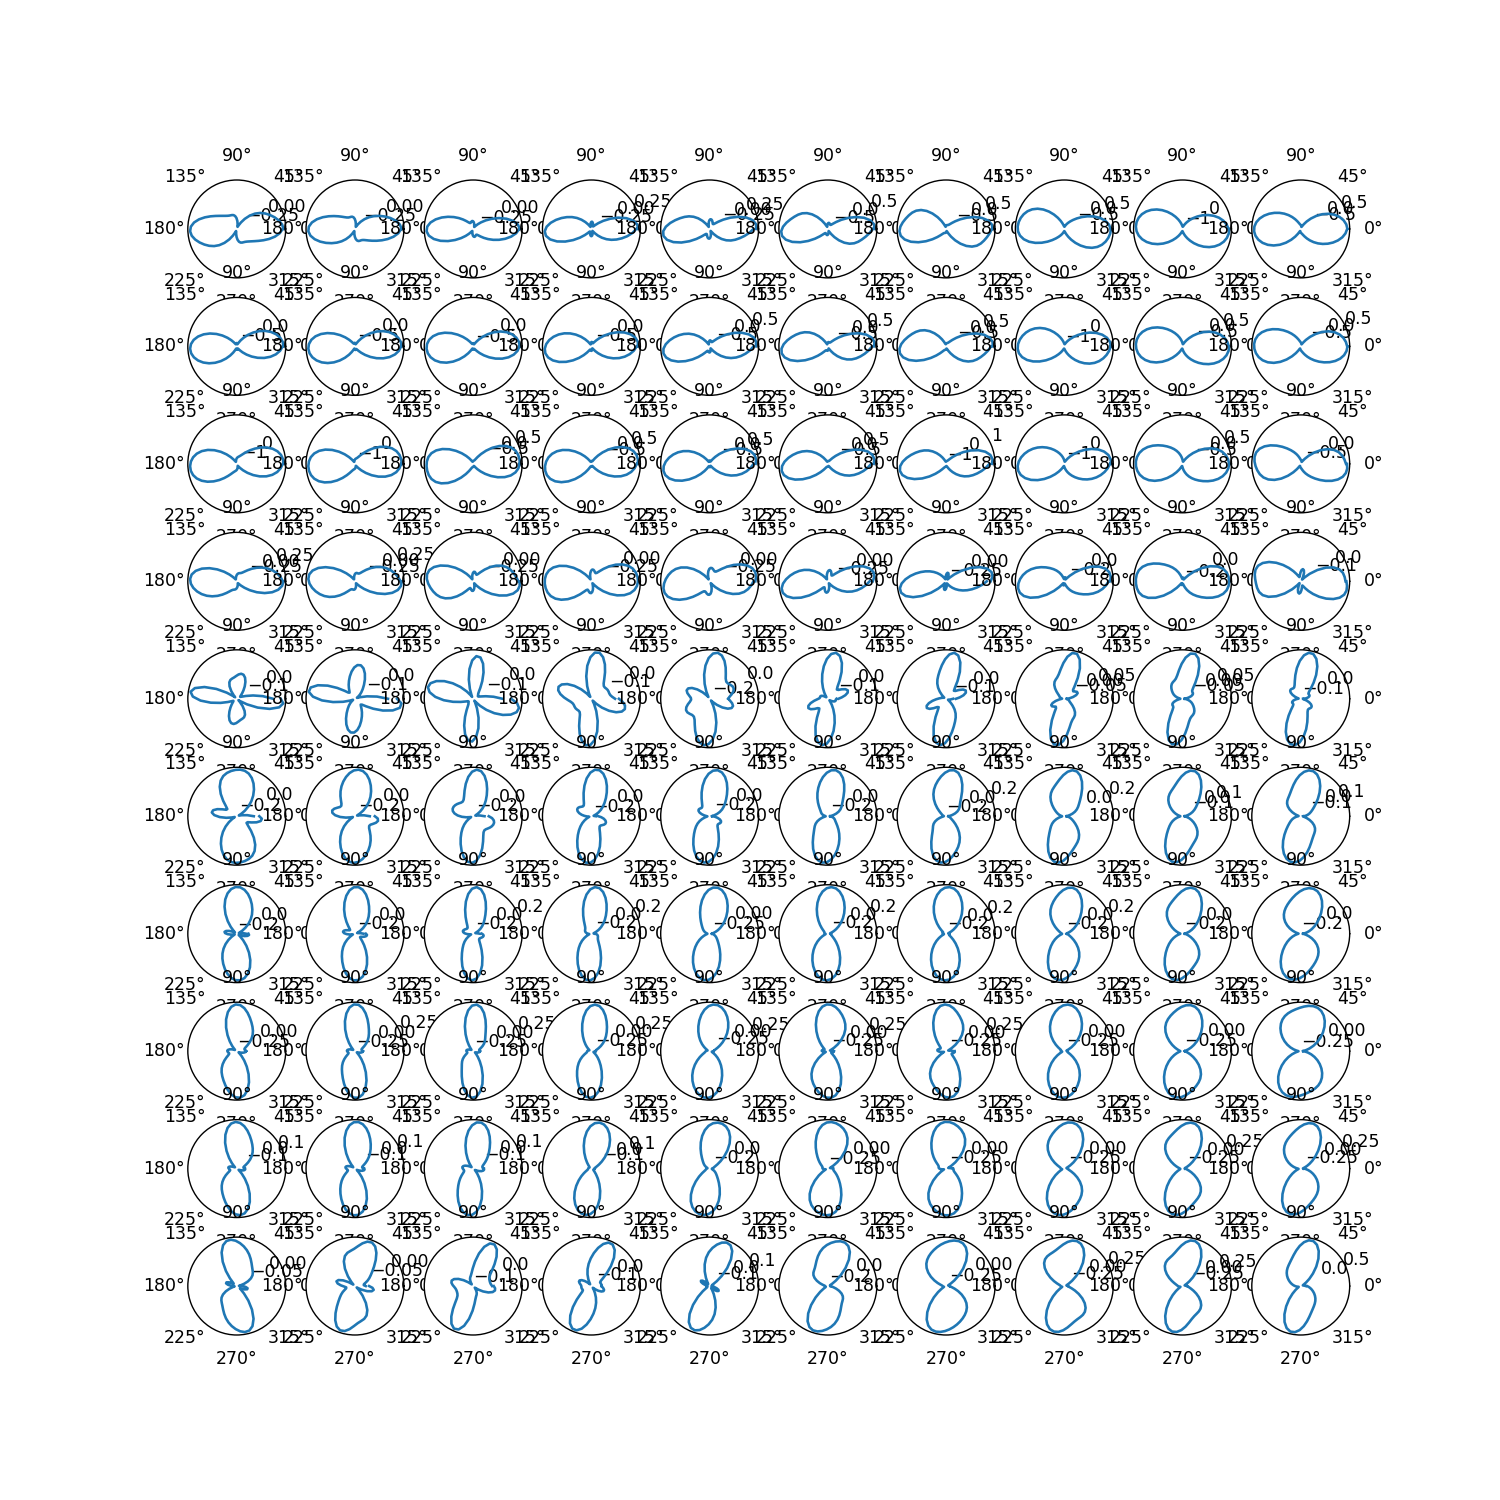

In [40]:
Ntheta = 63
t = np.arange(Ntheta+1)/Ntheta*2.0*np.pi
fig, axs = plt.subplots(nrows=10, ncols=10, subplot_kw={'projection':'polar'}, figsize=(12,12))
for i in range(10):
    for j in range(10):
        axs[i][j].plot(t,cf[:,64,120+j,159-i])
        axs[i][j].grid(False)